# Statystyki głosek (bardziej niz liter)
Chcemy policzyć statystyki występowania i liter i liter następnych dla języka polskiego.
Do tego potrzebny cleanup:
1. Usunąć wszystkie znaki poza literami polskiego alfabetu i spacjami.
1. Na końcu linii dopisać spację, żeby zliczało się jako litera na końcu zdania.
1. Czytać głoska po głosce z uwzględnieniem `sz`, `cz`, `rz`, `dz`, `dż`, `dź`, `dzi`, `si`, `ci`, `ch`
1. Rozbić `dzi`=`dź`, `si`=`ś`, `ci`=`ć`, `ni`=`ń` na np `dz`+`i` jeśli po nich występuje spółgłoska
 - np dźecko, dziwig (?!?), nigdźebądź

In [1]:
import re

clean_pattern = re.compile(r'(\W|\d|_)+')
def cleanup(t):
    return re.sub(clean_pattern, ' ', t.lower())+' '

cleanup("Nie! 11  dąsać się-pROszę")

'nie dąsać się proszę '

In [17]:
split_pattern = re.compile(r'(sz|cz|rz|dzi|dz|dź|dż|ch|si|ci|ni)')
def dziel(t):
    pos = 0
    for m in re.finditer(split_pattern, t):
        s = m.span()
        if m.start() != pos:
            for c in t[pos:m.start()]:
                yield c
        yield m[1]
        pos = m.end()
    if pos < len(t):
        for c in t[pos:]:
            yield c

print(list(dziel('zaszczute rzeźnickie dżdżownice dźwięczą dzisiaj dzdz ')))

['z', 'a', 'sz', 'cz', 'u', 't', 'e', ' ', 'rz', 'e', 'ź', 'ni', 'c', 'k', 'i', 'e', ' ', 'dż', 'dż', 'o', 'w', 'ni', 'c', 'e', ' ', 'dź', 'w', 'i', 'ę', 'cz', 'ą', ' ', 'dzi', 'si', 'a', 'j', ' ', 'dz', 'dz', ' ']


In [3]:
def czy_samlgloska(s):
    return s in ['a','i','e','o','y','u','ę','ą','ó']

def czy_spolgloska(s):
    return str.isalpha(s) and not czy_samlgloska(s)

Z `ś` + `si` oraz `ć` + `ci` to nie jest oczywiste. Jeśli po niej jest samogłoska, to chciłoby się uzyć `ś` a jeśli spółgłoska, to lepiej osobno `s` `i` (ze względu na komplikacje przy powtórzonych samogłoskach).
Podobną regułę moza przyjąć dla `dź` + `dzi`.

In [4]:
def popraw(iter):
    prev = next(iter)
    for g in iter:
        if prev in ['si', 'ci', 'ni', 'dzi'] and czy_spolgloska(g):
            yield prev[:-1]
            yield 'i'
        else:
            yield prev
        prev = g
    yield prev

print(list(popraw(dziel('sieć i sito dzisiaj dziadek ciepło ciska'))))

['si', 'e', 'ć', ' ', 'i', ' ', 's', 'i', 't', 'o', ' ', 'dz', 'i', 'si', 'a', 'j', ' ', 'dzi', 'a', 'd', 'e', 'k', ' ', 'ci', 'e', 'p', 'ł', 'o', ' ', 'c', 'i', 's', 'k', 'a']


In [5]:
def increase(d, k, x = 1):
    if k in d:
        d[k] += x
    else:
        d[k] = x

def sort_occ(c):
    return sorted(list(c), key=lambda p: p[1], reverse=True)

def cnt(d, k):
    if k in d:
        return d[k]
    else:
        return 0

class Stats:
    def __init__(self) -> None:
        self.global_count = 0
        self.count = {}
        self.sub_count = {}

    def _stat(self, ps, s):
        self.global_count += 1
        increase(self.count, ps)
        if ps not in self.sub_count:
            self.sub_count[ps] = {}
        increase(self.sub_count[ps], s)

    def stat(self, s):
        ps = ' '
        for s in popraw(dziel(cleanup(s))):
            self._stat(ps, s)
            ps = s

    def file_stat(self, name):
        with open(name) as f:
            for line in f:
                self.stat(line)

    def sorted(self):
        return sort_occ(self.count.items())

    def sorted_occ(self, k):
        return sort_occ(self.sub_count[k].items())

    def dodaj(self, k, zlodlo, k2):
        zc = cnt(zlodlo.count, k2)
        self.global_count += zc
        increase(self.count, k, zc)
        for kk, cc in zlodlo.sub_count[k2].items():
            if k not in self.sub_count:
                self.sub_count[k] = {}
            increase(self.sub_count[k], kk, cc)

    def scal(self, ks):
        kk = '+'.join(ks)
        for k in ks:
            self.dodaj(kk, self, k)
            self.count.pop(k)        
        # TODO scal sub_count


stat = Stats()
stat.stat('Zaszczute')

stat.count

{' ': 1, 'z': 1, 'a': 1, 'sz': 1, 'cz': 1, 'u': 1, 't': 1, 'e': 1}

In [6]:
stat = Stats()
stat.file_stat('34079-0.txt')
stat.file_stat('8119-0.txt')
stat.global_count

376241

In [7]:
import matplotlib.pyplot as plt

def rysuj_czestosc(ss):
    x = [p[0] for p in ss]
    y = [p[1] for p in ss]
    fig = plt.figure(figsize = (20, 10))
    plt.barh(x,y)
    plt.show(fig)

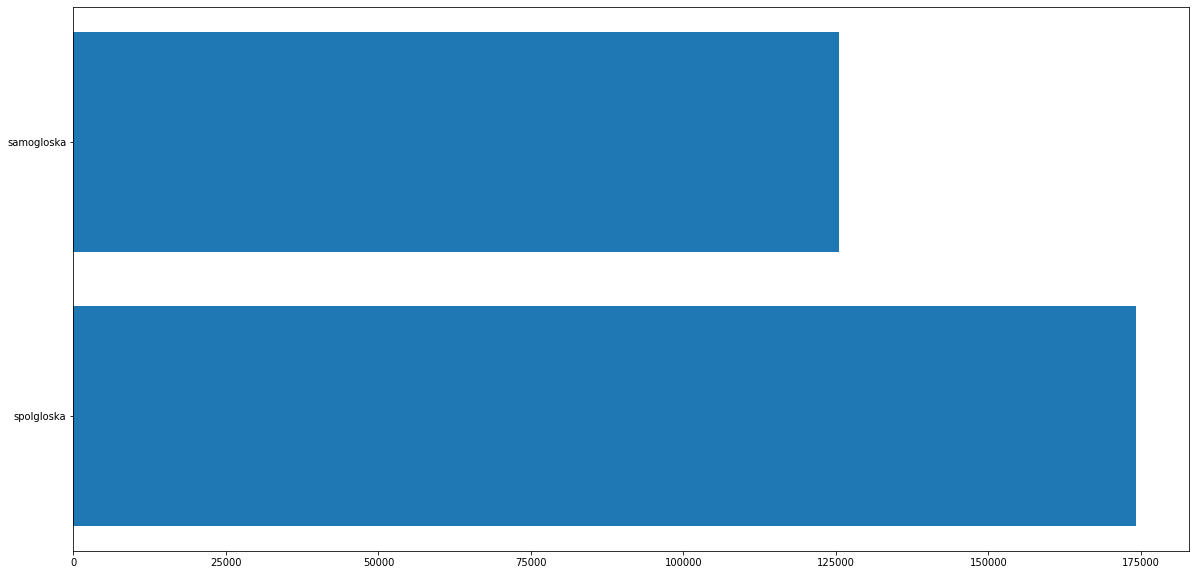

In [8]:
sp_czy_sam = Stats()
for k in list(stat.count.keys()):
    if czy_samlgloska(k):
        sp_czy_sam.dodaj('samogloska', stat, k)
    elif czy_spolgloska(k):
        sp_czy_sam.dodaj('spolgloska', stat, k)
    else:
        if k != ' ':
            sp_czy_sam.dodaj('inne', stat, k)

rysuj_czestosc(sp_czy_sam.sorted())

Co jest po spółgłosce?

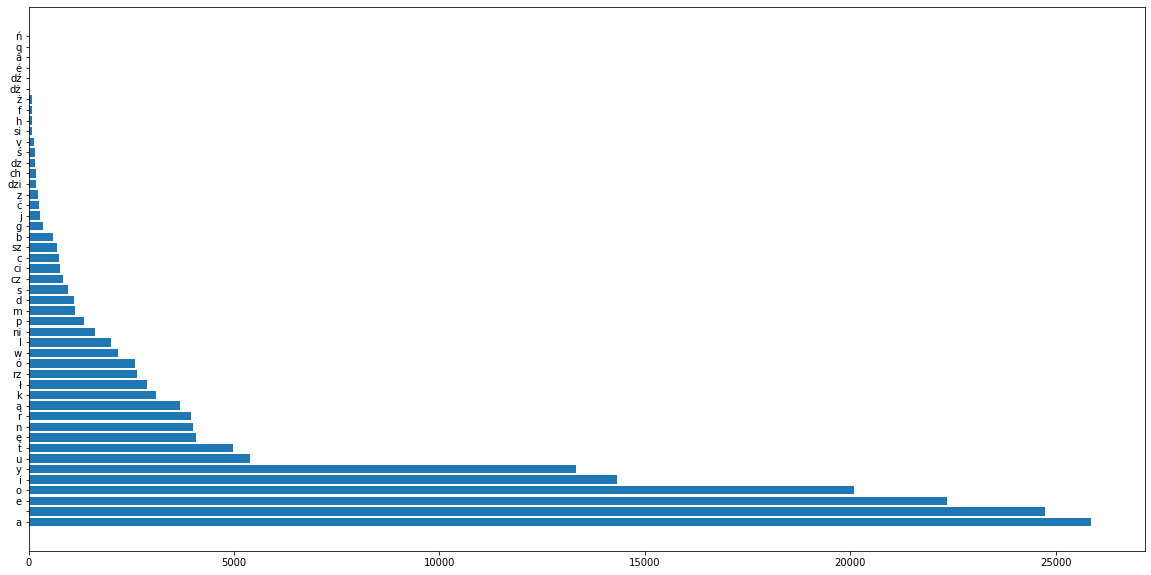

In [9]:
rysuj_czestosc(sp_czy_sam.sorted_occ('spolgloska'))

Co jest po samogłosce?

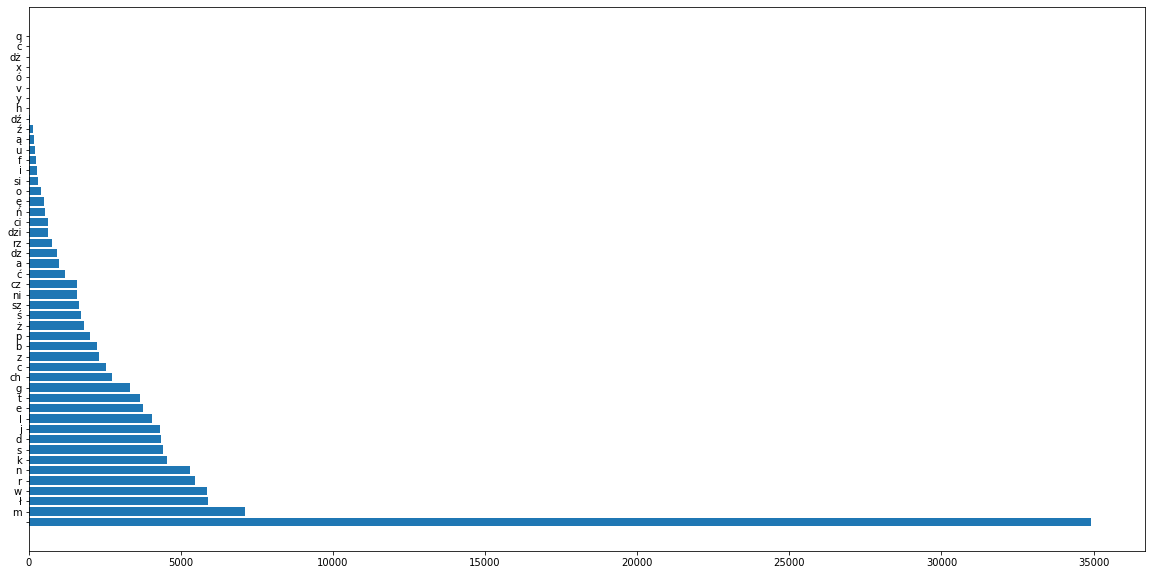

In [10]:
rysuj_czestosc(sp_czy_sam.sorted_occ('samogloska'))

## Obserwacje
1. Po spółgłosce `e` jest na 2 miejscu statystyk
1. Po samogłosce `e` występuje średnio często
1. Wyrazy częściej kończą się po samogłosce niz po spółgłosce
1. `ł` oraz `l` występują dość często i po spółgłosce i po samogłosce -- na tyle często, ze warto mieć osobny symbol na nie

## Scalanie
Idea jest taka jak ogonki i kreseczki. Niektóre głoski chcemy utozsamić (np `dź` i `dzi`), inne rozrózniać tylko za pomocą ogonka.

In [11]:

stat.dodaj('a1', stat, 'ś')
stat.dodaj('a1', stat, 'ć')
stat.dodaj('a1', stat, 'dź')
stat.dodaj('a1', stat, 'ź')
stat.dodaj('a1', stat, 'ń')

stat.dodaj('a1', stat, 'si')
stat.dodaj('a1', stat, 'ci')

stat.dodaj('a2', stat, 'sz')
stat.dodaj('a2', stat, 'cz')
stat.dodaj('a2', stat, 'dż')
stat.dodaj('a2', stat, 'rz')
stat.dodaj('a2', stat, 'ż')

stat.scal(['s', 'ś', 'si', 'sz'])
stat.scal(['c', 'ć', 'ci', 'cz'])
stat.scal(['d', 'dź', 'dzi', 'dż'])
stat.scal(['z', 'ż', 'rz', 'ź'])
stat.scal(['h', 'ch'])
stat.scal(['ó', 'u'])
stat.scal(['n', 'ń', 'ni'])

In [12]:
stat.sorted()

[(' ', 76505),
 ('a', 28022),
 ('e', 26223),
 ('o', 23452),
 ('n+ń+ni', 17802),
 ('i', 16872),
 ('s+ś+si+sz', 16551),
 ('w', 13570),
 ('z+ż+rz+ź', 13441),
 ('y', 13367),
 ('a2', 12711),
 ('t', 11907),
 ('m', 11332),
 ('r', 10661),
 ('c+ć+ci+cz', 10660),
 ('k', 9760),
 ('p', 9642),
 ('d+dź+dzi+dż', 9440),
 ('ó+u', 9095),
 ('a1', 9014),
 ('ł', 8996),
 ('j', 6987),
 ('l', 6932),
 ('b', 5209),
 ('g', 5102),
 ('ę', 4588),
 ('h+ch', 4091),
 ('ą', 3882),
 ('dz', 1270),
 ('f', 705),
 ('v', 154),
 ('x', 14),
 ('é', 4),
 ('q', 2),
 ('â', 2),
 ('ċ', 1)]

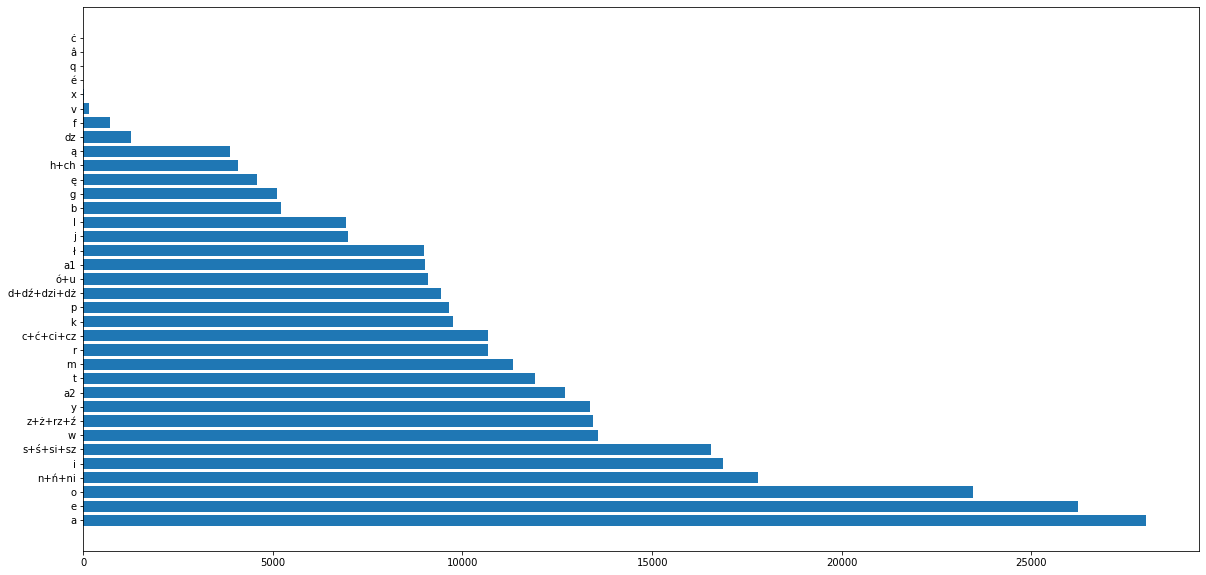

In [13]:

ss = stat.sorted()
ss.remove(ss[0]) # space
rysuj_czestosc(ss)

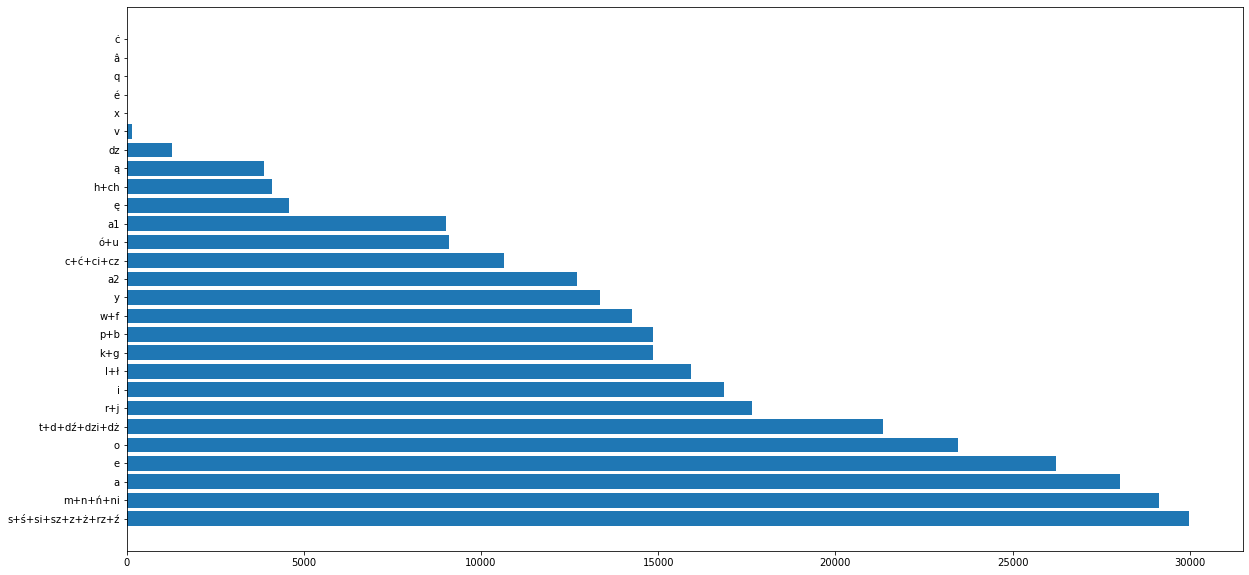

In [14]:
stat.scal(['t', 'd+dź+dzi+dż']) # ~
stat.scal(['m', 'n+ń+ni']) # n > m
stat.scal(['k', 'g']) # k > g
stat.scal(['w', 'f']) # w > f
stat.scal(['p', 'b']) # p > b
stat.scal(['l', 'ł']) # ~
stat.scal(['r', 'j']) # r > j
stat.scal(['s+ś+si+sz', 'z+ż+rz+ź']) # s > z

ss = stat.sorted()
ss.remove(ss[0]) # space
rysuj_czestosc(ss)

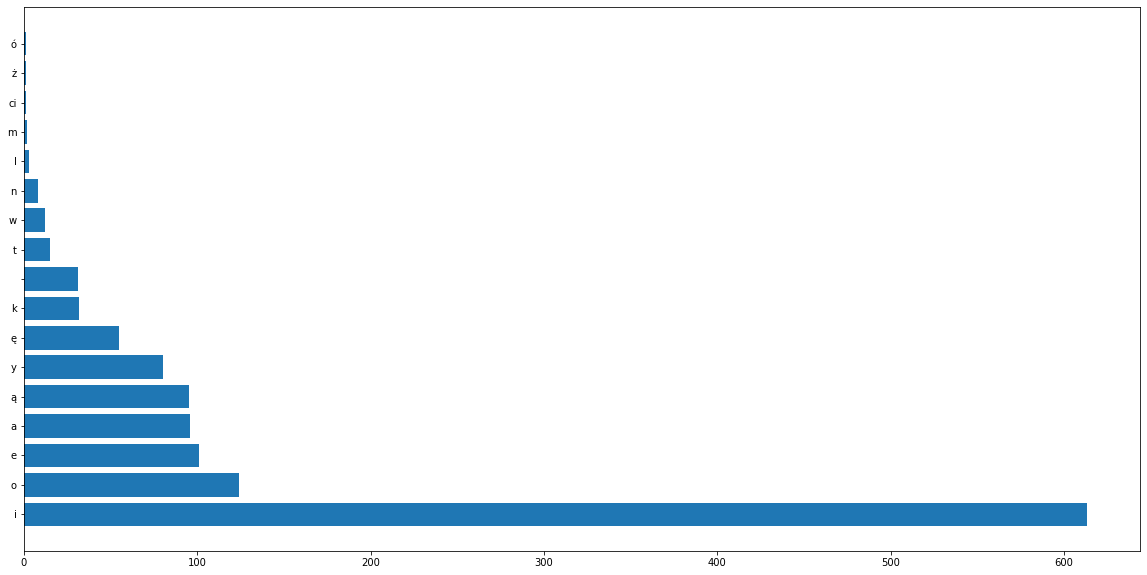

In [15]:
rysuj_czestosc(stat.sorted_occ('dz'))

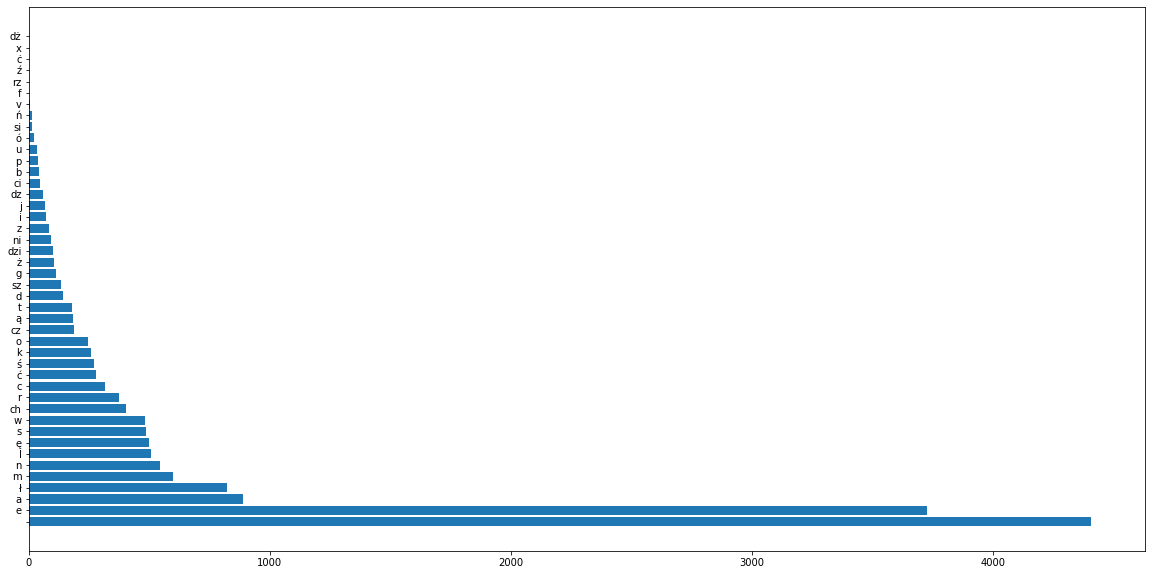

In [16]:
rysuj_czestosc(stat.sorted_occ('i'))

`ie` ma podobną częstość występowania jak `h` (mimo oddzielnych `dzi`, `si`, `ci`, `ni`). Dlatego dobrze byłoby mieć dla niej jakiś skrót w zapisie.